## Numerical Experiment 2: Perplexity as a metric for generalization

In [1]:
# Import libraries
import tqdm
import math
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import confusion_matrix
from scipy.special import digamma, polygamma
inverse = lambda X: np.linalg.inv(X)

In [2]:
# Import implemented functions
from lda import VariationalInference, ParameterEstimation, ParameterEstimationExtended
from utils import discreteNormal, discretePoisson

In [5]:
# Data generation with 4 topics
np.random.seed(17)
K  = 4
P  = 10
M  = 100
N  = 100
M1 = 10
N1 = 10
words = list(range(10))
alpha = np.array([1., 1., 1.5, 1.5])
dist0 = discreteNormal(P, 3.4, np.sqrt(1.))
dist1 = discreteNormal(P, 5.6, np.sqrt(1.))
dist2 = discretePoisson(P, 1., reverse = False)
dist3 = discretePoisson(P, 1., reverse = True)
beta  = np.vstack([dist0, dist1, dist2, dist3])

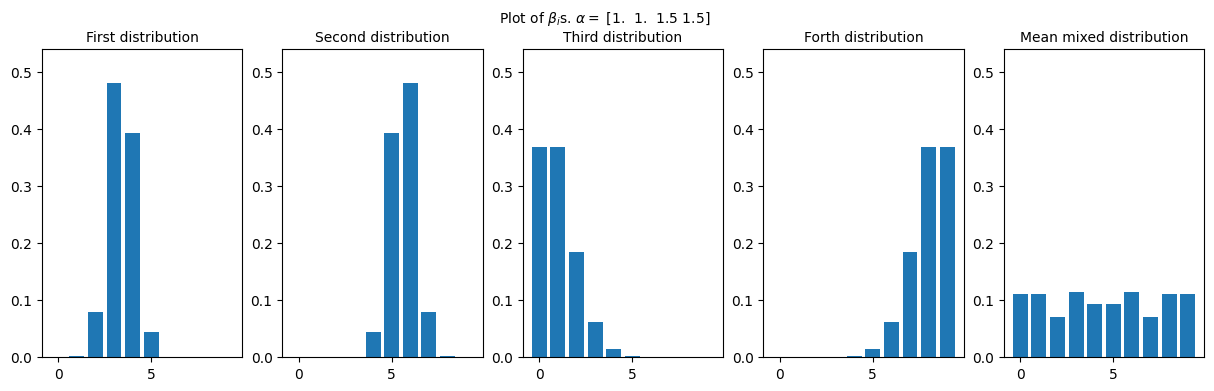

In [6]:
# Ploting of parameters
fig, ax = plt.subplots(1, 5, figsize=(15, 4))
for a in ax.flat:
    a.set_ylim(top=0.54)
ax[0].bar(words, dist0)
ax[0].set_title('First distribution', fontsize=10)
ax[1].bar(words, dist1)
ax[1].set_title('Second distribution', fontsize=10)
ax[2].bar(words, dist2)
ax[2].set_title('Third distribution', fontsize=10)
ax[3].bar(words, dist3)
ax[3].set_title('Forth distribution', fontsize=10)
ax[4].bar(words, alpha @ beta / sum(alpha))
ax[4].set_title('Mean mixed distribution', fontsize=10)
fig.suptitle(r'Plot of $\beta_i$s. $\alpha=$ ' + str(alpha), fontsize=10)
plt.show()

In [7]:
# Data generation
dataset = []
for _ in range(M):
    theta = np.random.dirichlet(alpha) @ beta
    dataset.append(np.random.choice(P, N, p=theta, replace=True))

# Also generating holdout data
dataset_test1 = []
for _ in range(M1):
    theta = np.random.dirichlet(alpha) @ beta
    dataset_test1.append(np.random.choice(P, N1, p=theta, replace=True))

# Generating data from uniformly random choice model
dataset_test2 = []
for _ in range(M1):
    dataset_test2.append(np.random.choice(P, N1, replace=True))

In [8]:
num_iter_EM = 100
alpha_hat, beta_hat, perplexity = ParameterEstimationExtended(dataset, K, P, [dataset_test1, dataset_test2], \
                                                              num_iter_MC=400, num_iter_VI=10, num_iter_NR=3, num_iter_EM=num_iter_EM)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


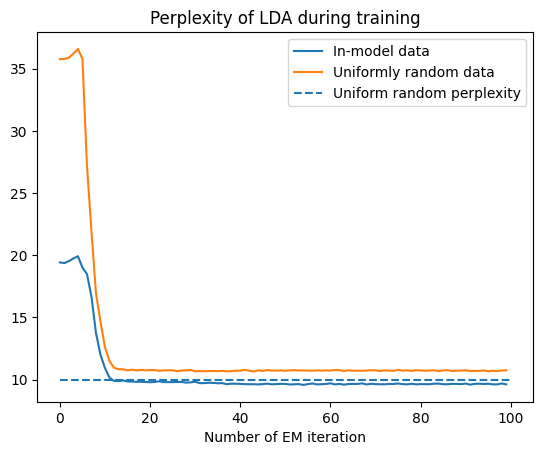

In [41]:
plt.plot(perplexity[0], label='In-model data')
plt.plot(perplexity[1], label='Uniformly random data')
plt.hlines(y=P, xmin=0, xmax=num_iter_EM, linestyles = ['--'], label='Uniform random perplexity')
plt.title('Perplexity of LDA during training')
plt.xlabel('Number of EM iteration')
plt.legend()
plt.show()

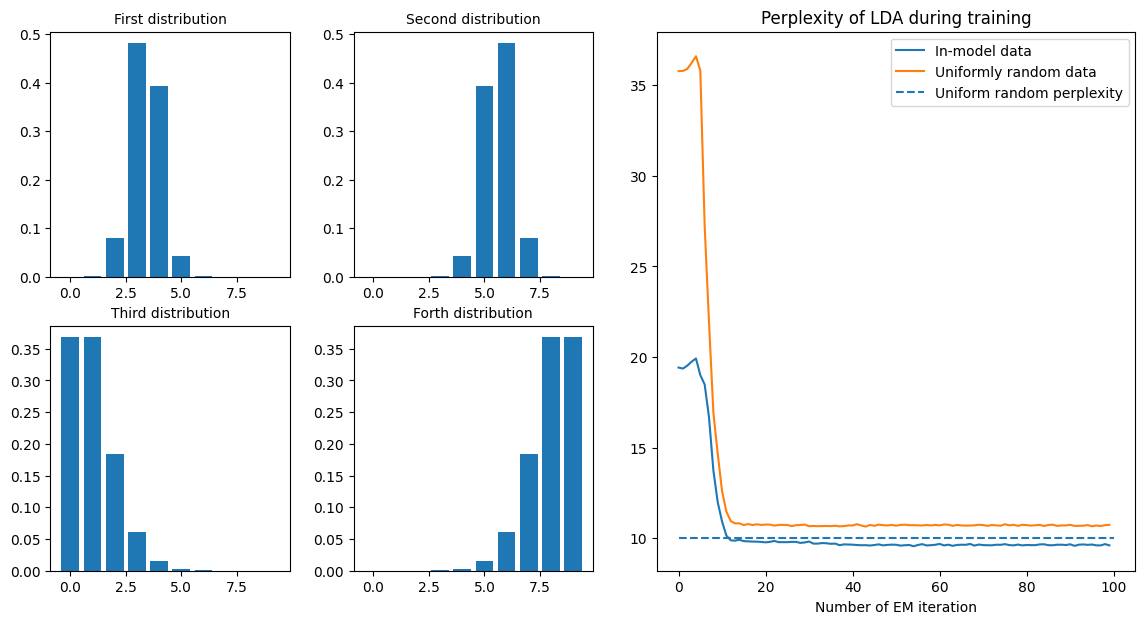

In [9]:
# Plotting for the report

# Create a figure and a gridspec layout
fig = plt.figure(figsize=(14, 7))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 2]) # Adjust width_ratios as needed

# Add subplots using the gridspec layout
ax1 = plt.subplot(gs[:, 2]) # Main plot spanning two rows
ax2 = plt.subplot(gs[0, 0])
ax3 = plt.subplot(gs[0, 1])
ax4 = plt.subplot(gs[1, 0])
ax5 = plt.subplot(gs[1, 1])

# Plotting
ax1.plot(perplexity[0], label='In-model data')
ax1.plot(perplexity[1], label='Uniformly random data')
ax1.hlines(y=P, xmin=0, xmax=num_iter_EM, linestyles = ['--'], label='Uniform random perplexity')
ax1.set_title('Perplexity of LDA during training')
ax1.set_xlabel('Number of EM iteration')
ax1.legend()
ax2.bar(words, dist0)
ax2.set_title('First distribution', fontsize=10)
ax3.bar(words, dist1)
ax3.set_title('Second distribution', fontsize=10)
ax4.bar(words, dist2)
ax4.set_title('Third distribution', fontsize=10)
ax5.bar(words, dist3)
ax5.set_title('Forth distribution', fontsize=10)
# fig.suptitle(r'Plot of groundtruth parameters and perplexity. $\alpha=$ ' + str(alpha), fontsize=10)
plt.savefig('exp2_plot1.jpg', bbox_inches='tight', format='jpeg')
plt.show()

In [ ]:
# perplexity[0][-5:]

In [10]:
perplexity[1][-5:]

[10.666957031693745,
 10.70950062820473,
 10.678442993910814,
 10.725853703166406,
 10.743106272308074]

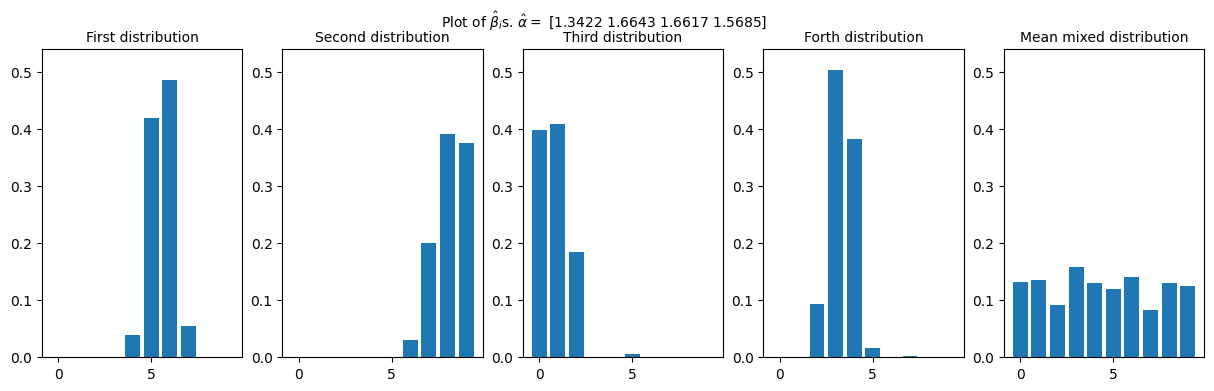

In [13]:
# Plot beta_hat - how does the fitting look?
fig, ax = plt.subplots(1, 5, figsize=(15, 4))
for a in ax.flat:
    a.set_ylim(top=0.54)
ax[0].bar(words, beta_hat[0])
ax[0].set_title('First distribution', fontsize=10)
ax[1].bar(words, beta_hat[1])
ax[1].set_title('Second distribution', fontsize=10)
ax[2].bar(words, beta_hat[2])
ax[2].set_title('Third distribution', fontsize=10)
ax[3].bar(words, beta_hat[3])
ax[3].set_title('Forth distribution', fontsize=10)
ax[4].bar(words, alpha_hat @ beta_hat / sum(alpha))
ax[4].set_title('Mean mixed distribution', fontsize=10)
fig.suptitle(r'Plot of $\hat\beta_i$s. $\hat\alpha=$ ' + str(np.round(alpha_hat, 4)), fontsize=10)
plt.show()

In [12]:
# Plot of final perplexity as a function of topic
K_max = 7
num_iter = 4
perplexities = []
for k in tqdm.tqdm(range(1, K_max+1)):
    temp = 0.
    for _ in range(num_iter):
        _, _, perplexity = ParameterEstimationExtended(dataset, K, P, [dataset_test1], printing = False, \
                                                       num_iter_MC=400, num_iter_VI=10, num_iter_NR=3, num_iter_EM=25)
        temp += perplexity[-1][-1]
    temp /= num_iter
    perplexities.append(temp)


100%|████████████████████████████████████████████████████████████████████████████████| 7/7 [07:24<00:00, 63.51s/it]


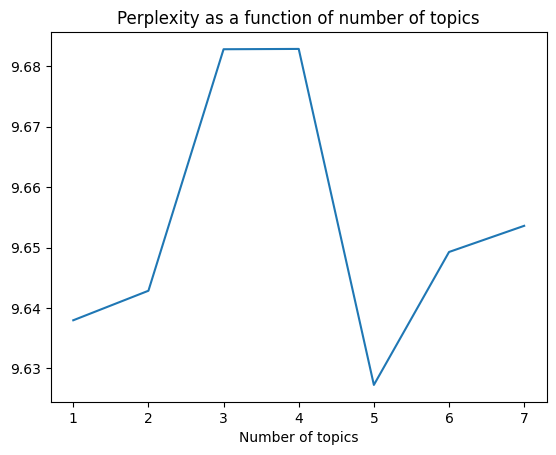

In [13]:
plt.plot(list(range(1, K_max+1)), perplexities)
plt.title('Perplexity as a function of number of topics')
plt.xlabel('Number of topics')
plt.savefig('exp2_plot3.jpg', format='jpeg')
plt.show()

In [14]:
# Data generation with 4 topics - attempt 2
np.random.seed(17)
K  = 4
P  = 10
M  = 100
N  = 100
M1 = 10
N1 = 10
alpha = np.array([0.75, 0.75, 0.75, 0.75])
dist0 = [0.46, 0.46, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
dist1 = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.46, 0.46]
dist2 = [0.01, 0.01, 0.01, 0.60, 0.32, 0.01, 0.01, 0.01, 0.01, 0.01]
dist3 = [0.01, 0.01, 0.01, 0.01, 0.01, 0.32, 0.60, 0.01, 0.01, 0.01]
beta  = np.vstack([dist0, dist1, dist2, dist3])

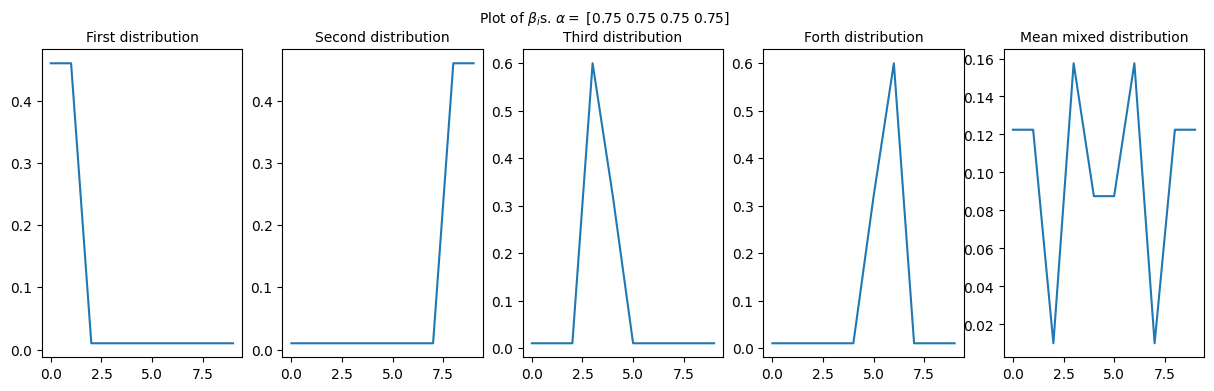

In [15]:
# Ploting of parameters
fig, ax = plt.subplots(1, 5, figsize=(15, 4))
ax[0].plot(dist0)
ax[0].set_title('First distribution', fontsize=10)
ax[1].plot(dist1)
ax[1].set_title('Second distribution', fontsize=10)
ax[2].plot(dist2)
ax[2].set_title('Third distribution', fontsize=10)
ax[3].plot(dist3)
ax[3].set_title('Forth distribution', fontsize=10)
ax[4].plot(alpha @ beta / sum(alpha))
ax[4].set_title('Mean mixed distribution', fontsize=10)
fig.suptitle(r'Plot of $\beta_i$s. $\alpha=$ ' + str(alpha), fontsize=10)
plt.show()

In [16]:
# Data generation
dataset = []
for _ in range(M):
    theta = np.random.dirichlet(alpha) @ beta
    dataset.append(np.random.choice(P, N, p=theta, replace=True))

# Also generating holdout data
dataset_test1 = []
for _ in range(M1):
    theta = np.random.dirichlet(alpha) @ beta
    dataset_test1.append(np.random.choice(P, N1, p=theta, replace=True))

# Generating data from uniformly random choice model
dataset_test2 = []
for _ in range(M1):
    dataset_test2.append(np.random.choice(P, N1, replace=True))

In [17]:
num_iter_EM = 100
alpha_hat, beta_hat, perplexity = ParameterEstimationExtended(dataset, K, P, [dataset_test1, dataset_test2], \
                                                              num_iter_MC=400, num_iter_VI=10, num_iter_NR=3, num_iter_EM=num_iter_EM)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


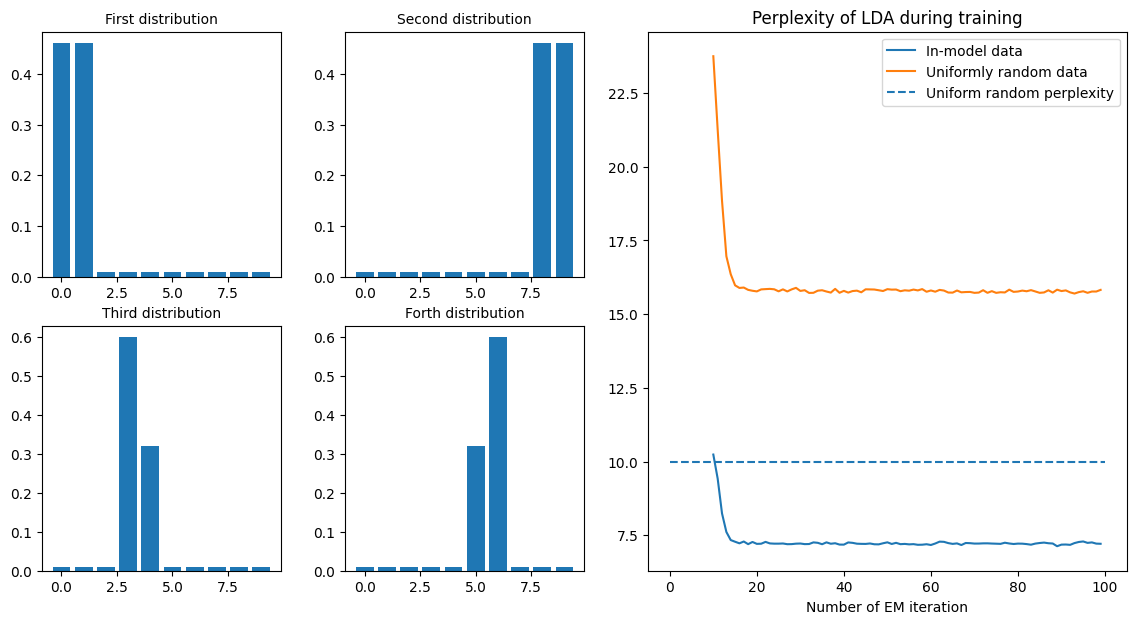

In [18]:
# Plotting for the report

# Create a figure and a gridspec layout
fig = plt.figure(figsize=(14, 7))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 2]) # Adjust width_ratios as needed

# Add subplots using the gridspec layout
ax1 = plt.subplot(gs[:, 2]) # Main plot spanning two rows
ax2 = plt.subplot(gs[0, 0])
ax3 = plt.subplot(gs[0, 1])
ax4 = plt.subplot(gs[1, 0])
ax5 = plt.subplot(gs[1, 1])

# Plotting
ax1.plot(perplexity[0], label='In-model data')
ax1.plot(perplexity[1], label='Uniformly random data')
ax1.hlines(y=P, xmin=0, xmax=num_iter_EM, linestyles = ['--'], label='Uniform random perplexity')
ax1.set_title('Perplexity of LDA during training')
ax1.set_xlabel('Number of EM iteration')
ax1.legend()
ax2.bar(words, dist0)
ax2.set_title('First distribution', fontsize=10)
ax3.bar(words, dist1)
ax3.set_title('Second distribution', fontsize=10)
ax4.bar(words, dist2)
ax4.set_title('Third distribution', fontsize=10)
ax5.bar(words, dist3)
ax5.set_title('Forth distribution', fontsize=10)
# fig.suptitle(r'Plot of groundtruth parameters and perplexity. $\alpha=$ ' + str(alpha), fontsize=10)
plt.savefig('exp2_plot2.jpg', bbox_inches='tight', format='jpeg')
plt.show()

In [19]:
perplexity[0][-5:]

[7.292807611711317,
 7.244925989797684,
 7.260849201694093,
 7.219937328883052,
 7.214279431808281]

In [20]:
perplexity[1][-5:]

[15.778008633478132,
 15.725671863919008,
 15.76971530251876,
 15.769289005781642,
 15.825023921188883]

In [21]:
perplexity[0][:5]

[nan, nan, nan, nan, nan]

In [22]:
perplexity[1][:5]

[nan, nan, nan, nan, nan]